# FDMT iteration data partitioning

Early iterations of the FDMT are readily partitioned by channel. But wwhat about the final iteration (which is depednant on both channels)? Can it be partitioned by DM? Let's find out!

In [2]:
from pylab import *
import matplotlib as mpl
import seaborn as sns
import calc11
import numpy as np
from scipy import constants
import fdmt # you'll need to have ../python in  you PYTHONPATH
from graphviz import Digraph
from collections import OrderedDict


%matplotlib inline

In [7]:

bw = 0.256 # bandwidth GHz
Nd = 1024 # number of DM trials
Nchan= 256*2
Nt = 16 # time block size
Tint = 0.864e-3 # integration time - seconds
Npol = 2 # input number of polarisations
Npix = 256
f1 = 0.716
chanbw = float(bw)/float(Nchan)
freqs = f1 + np.arange(Nchan)*chanbw
lambdas = constants.c / (freqs*1e9)
nbytes = 2
reload(fdmt)
thefdmt = fdmt.Fdmt(f1, chanbw, Nchan, Nd, Nt)
print 'INIT DELTA T', thefdmt.init_delta_t

for i in xrange(thefdmt.niter):
    ndout = thefdmt.ndm_out_for_iter(i)
    lastconf = thefdmt.get_config(i, 0, ndout-1)
    print 'Iter', i, 'nchan', thefdmt.nchan_out_for_iter(i), thefdmt.ndm_out_for_iter(i), thefdmt.hist_state_shape[i],thefdmt.hist_state_shape[i+1], 'last id1,id2,off', lastconf
    
print 'TESTCONF'
testconf = ((0, 1, 2), (thefdmt.niter-1, 0, Nd-1))
for iterno, chan, idt in testconf:
    id1, id2, offset = thefdmt.get_config(iterno, chan, idt)
    print 'iterno', iterno, 'idt', idt, 'chan', chan, 'id1', id1, 'id2', id2, 'offset', offset
    (f_start, f_end, f_middle, f_middle_larger, delta_t_local, idt_data) = thefdmt.hist_nf_data[iterno][chan]
    print 'Chaninfo', f_start, f_end, f_middle, f_middle_larger, delta_t_local

    

INIT DELTA T 5
Iter 0 nchan 256 8 [512   5  16] [256   8  24] last id1,id2,off (2, 2, 5)
Iter 1 nchan 128 14 [256   8  24] [128  14  30] last id1,id2,off (5, 5, 8)
Iter 2 nchan 64 26 [128  14  30] [64 26 42] last id1,id2,off (11, 11, 14)
Iter 3 nchan 32 51 [64 26 42] [32 51 67] last id1,id2,off (24, 23, 27)
Iter 4 nchan 16 98 [32 51 67] [ 16  98 114] last id1,id2,off (48, 46, 51)
Iter 5 nchan 8 189 [ 16  98 114] [  8 189 205] last id1,id2,off (96, 89, 99)
Iter 6 nchan 4 354 [  8 189 205] [  4 354 370] last id1,id2,off (186, 164, 189)
Iter 7 nchan 2 629 [  4 354 370] [  2 629 645] last id1,id2,off (351, 274, 354)
Iter 8 nchan 1 1024 [  2 629 645] [   1 1024 1040] last id1,id2,off (626, 395, 628)
TESTCONF
iterno 0 idt 2 chan 1 id1 1 id2 0 offset 2
Chaninfo 0.717 0.718 0.71725 0.71775 8
iterno 8 idt 1023 chan 0 id1 626 id2 395 offset 628
Chaninfo 0.716 0.972 0.84375 0.84425 1024


In [53]:

len(thefdmt.hist_nf_data[0][0][-1])


8

In [231]:
# we'll look throught the final iteration and see what the largest idt of the input channels is used.
curr_iterno = 5
prev_iterno = curr_iterno - 1
ochan = 0
chanconfig = thefdmt.hist_nf_data[curr_iterno][ochan][-1]
c0conf = thefdmt.hist_nf_data[curr_iterno-1][2*ochan][-1]
c1conf = thefdmt.hist_nf_data[curr_iterno-1][2*ochan+1][-1]

def findidts(theid, chanconfig):
    for idt, config in enumerate(chanconfig):
        _, id1, offset, id2, _, _, _ = config
        if (theid == id1) or (theid == id2):
            yield idt

idin = np.zeros((len(chanconfig), 2))
for idt, config in enumerate(chanconfig):
    _, id1, offset, id2, _, _, _ = config
    # id1 is the idt for channel 0
    # id2 is the idt for channel 1
    # But: What other idts in this teration need those idts?
    i1_idts = list(findidts(id1, chanconfig))
    i2_idts = list(findidts(id2, chanconfig))
    
    
    idin[idt, 0] = min(i1_idts)
    idin[idt, 1] = min(i2_idts)
        


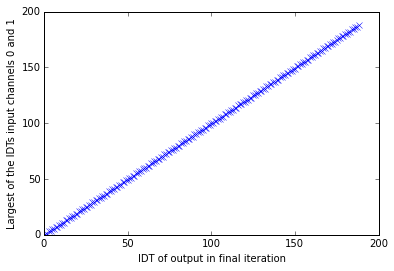

In [232]:
ids = np.arange(len(chanconfig))
imax = idin.max(axis=1)
plot(ids, imax,'x')
xlabel('IDT of output in final iteration')
ylabel('Largest of the IDTs input channels 0 and 1')

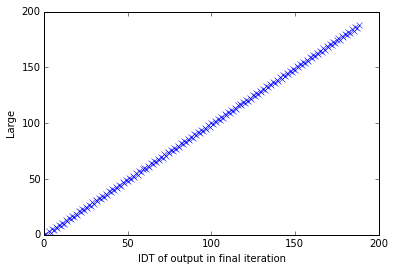

In [233]:
plot(ids, idin.max(axis=1)*2 - ids, 'x')
xlabel('IDT of output in final iteration')
ylabel('Large')


Adjacent IDT are monotinically increasing? True


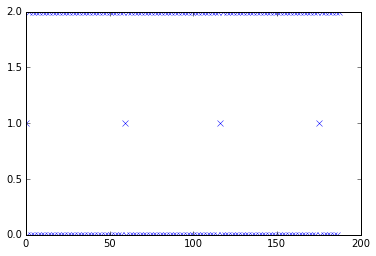

In [234]:
idiff = imax[1:] - imax[0:-1]
plot(idiff, 'x')
print 'Adjacent IDT are monotinically increasing?', np.all(idiff >= 0)

(0, 10)

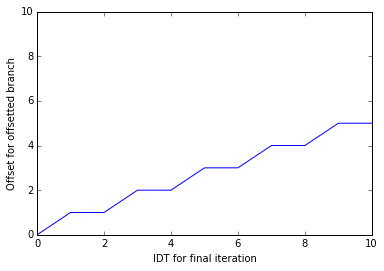

In [235]:
ochan = 0
chanconfig = thefdmt.hist_nf_data[curr_iterno][ochan][-1]
offsets = np.array([config[2] for config in chanconfig])
#        _, id1, offset, id2, _, _, _ = config
id1s = np.array([config[1] for config in chanconfig])
id2s = np.array([config[3] for config in chanconfig])

plot(offsets)
xlabel('IDT for final iteration')
ylabel('Offset for offsetted branch')
xlim(0,10)
ylim(0,10)

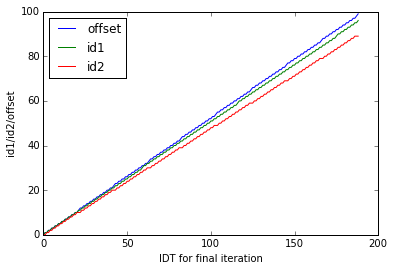

In [236]:
idts = np.arange(len(offsets))
plot(idts, offsets, label='offset')
plot(idts, id1s, label='id1')
plot(idts, id2s, label='id2')
xlabel('IDT for final iteration')
ylabel('id1/id2/offset')
#xlim(0,100)
#ylim(0,60)
legend(loc='upper left')

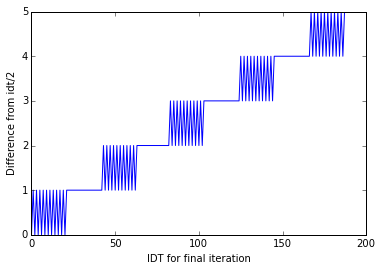

In [237]:
plot(idts, offsets - idts/2)
xlabel('IDT for final iteration')
ylabel('Difference from idt/2')

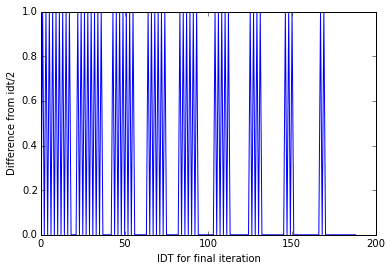

In [238]:
idts = np.arange(len(offsets))
offlin = idts*offsets.max()/idts.max()
plot(idts, offsets - offlin)
xlabel('IDT for final iteration')
ylabel('Difference from idt/2')

(-0.5, 1.4)

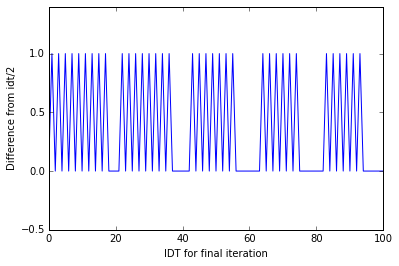

In [239]:
plot(idts, offsets - offlin)

xlabel('IDT for final iteration')
ylabel('Difference from idt/2')
xlim(0, 100)
ylim(-0.5, 1.4)

(-0.5, 1.4)

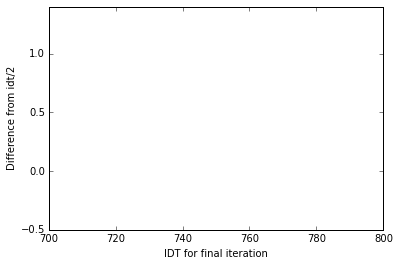

In [240]:
plot(idts, offsets - offlin)

xlabel('IDT for final iteration')
ylabel('Difference from idt/2')
xlim(700, 800)
ylim(-0.5, 1.4)

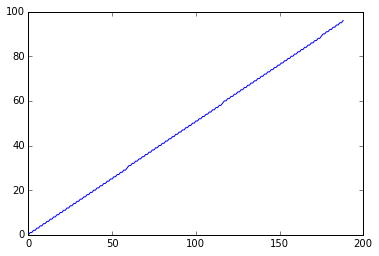

In [241]:
plot(id1s)

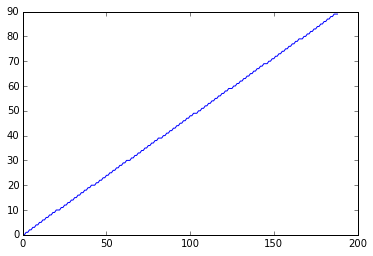

In [242]:
plot(id2s)

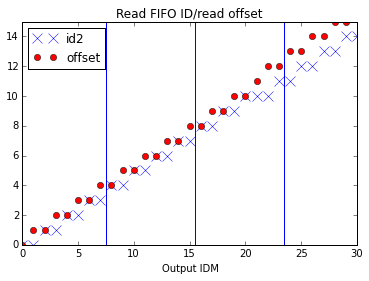

In [243]:
plot(id2s,'bx', ms=10, label='id2')
plot(offsets,'ro', label='offset')
xlim(0,30)
ylim(0,15)
title('Read FIFO ID/read offset')
xlabel('Output IDM')
axvline(7.5)
axvline(15.5)
axvline(15.5+8)
legend(loc='upper left')


array shape is idsmax=89 offsetsmax=99 bank_size=91 [10 10 10] [10 11 12] [ 920 1011 1102] [ 8  3 14] [57 63 68]


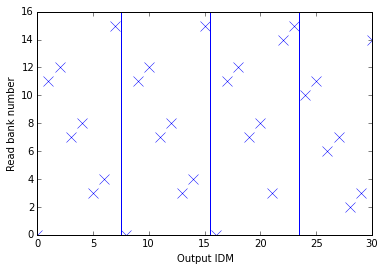

In [244]:
#idx = offsets + offsets.max()*id2s
# nbank=16
# size_per_bank = ndm * nchan / nbank
# My array fifos[nbank][size_per_bank]
bank_size=id2s.max()+2
idx = id2s + bank_size*offsets
# fdmt_t fifos[NBANKS][SIZE_OF_BANK]

nbank = 16
bank = idx % nbank
address = idx // nbank
plot(bank,'bx', ms=10, label='bank')
xlim(0,30)
#ylim(0,1000)
ylabel('Read bank number')
xlabel('Output IDM')
axvline(7.5)
axvline(15.5)
axvline(15.5+8)
#legend(loc='upper left')
dmrange = slice(20, 23)
print "array shape is idsmax=%d offsetsmax=%d bank_size=%d"%(id2s.max(), offsets.max(), bank_size), id2s[dmrange], offsets[dmrange], idx[dmrange], bank[dmrange], address[dmrange]

# id1 , id2, offset
# data[chan, idm] = data[2*chan, id1] + fifos[2*chan+1, id2, offset]
# id1 = int(round(idm*complicated_function(chan, iter, center_frequecy)))
#     = int(round(idm*coeff1))
# offset = int(round(idm * complicated_function(chan, iter, center_frequecy+0.5)))
#        = int(round(idm*coeff2))
# id2 = idm - id1
# idx = id2 + BANK_SIZE*offset
#     = (idm - id1) + BANK_SIZE*offset
# bank = idx % 16
#      = (idm - id1 + BANK_SIZE*offset)%16
#      = (idm%16 - (id1%16) + (BANK_SIZE*offset)%16) %16
#      = (idm%16 - (int(round(idm*coeff1))%16) + (BANK_SIZE*int(round(idm*coeff2)))%16) %16
#      = (idm - int(round(idm*coeff1) + int(round(idm*coeff2))*BANK_SIZE))%16
#      = ((idm - int(round(idm*coeff1))%16 + int(round(idm*coeff2))*BANK_SIZE%16))


In [245]:
bank_per_call = bank[0:(len(bank)//8)*8].reshape(-1,8)
print bank_per_call[0,:]
print len(np.unique(bank_per_call[0,:]))

[ 0 11 12  7  8  3  4 15]
8


In [246]:
call_unique = [len(np.unique(bank_per_call[icall, :])) for icall in xrange(bank_per_call.shape[0])]
print np.unique(call_unique)
if len(np.unique(call_unique)) == 1:
    print 'Everything is OK'
else:
    print '*'*10, 'AARRGH! Not unique ports', '*'*10

[8]
Everything is OK


nsamp 184
[ 0  0  1  1  2  2  3  3  4  4  5  5  6  6  7  7  8  8  9  9 10 10 10 11
 11 12 12 13 13 14 14 15 15 16 16 17 17 18 18 19 19 20 20 20 21 21 22 22
 23 23 24 24 25 25 26 26 27 27 28 28 29 29 30 30 30 31 31 32 32 33 33 34
 34 35 35 36 36 37 37 38 38 39 39 39 40 40 41 41 42 42 43 43 44 44 45 45
 46 46 47 47 48 48 49 49 49 50 50 51 51 52 52 53 53 54 54 55 55 56 56 57
 57 58 58 59 59 59 60 60 61 61 62 62 63 63 64 64 65 65 66 66 67 67 68 68
 69 69 69 70 70 71 71 72 72 73 73 74 74 75 75 76 76 77 77 78 78 79 79 79
 80 80 81 81 82 82 83 83 84 84 85 85 86 86 87 87 88 88 89 89 89]
[ 0 11 22 33 44 55 66 77  0 11 22 33 44 55 66 77  1 12 23 34 45 56 67 78
  1 12 23 34 45 56 67 78  2 13 24 35 46 57 68 79  2 13 24 35 46 57 68 79
  3 14 25 36 47 58 69 79  3 14 25 36 47 58 69 80  4 15 26 37 48 59 69 80
  4 15 26 37 48 59 70 81  5 16 27 38 49 59 70 81  5 16 27 38 49 60 71 82
  6 17 28 39 49 60 71 82  6 17 28 39 50 61 72 83  7 18 29 39 50 61 72 83
  7 18 29 40 51 62 73 84  8 19 30 40 51 62 73 84 

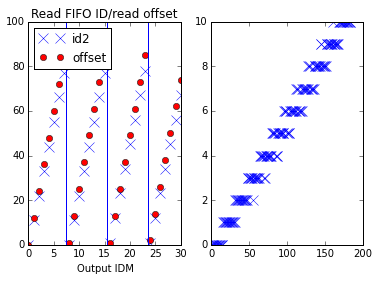

In [257]:
# Try this idea - why don't we do block instead of cyclic
nbank = 11
nread = 8
nsamp = (len(id2s)//nread)*nread
print 'nsamp', nsamp
id2st = id2s[0:nsamp].reshape(nread, -1).T.flatten()
print id2s
print id2st
offsetst = offsets[0:nsamp].reshape(nread, -1).T.flatten()

# fdmt_t fifos[NBANKS][SIZE_OF_BANK]
fig, ax = subplots(1,2)
bank = id2st % nbank
address = idx // nbank
#plot(bank,'bx', ms=10, label='BankID')
ax[0].plot(id2st,'bx', ms=10, label='id2')
ax[0].plot(offsetst,'ro', label='offset')
ax[0].set_xlim(0,30)
ax[0].set_title('Read FIFO ID/read offset')
ax[0].set_xlabel('Output IDM')
for i in xrange(3):
    ax[0].axvline(nread*(i+1) - 0.5)
    
ax[0].legend(loc='upper left')
ax[1].plot(bank,'bx', ms=10, label='bank')


#legend(loc='upper left')
dmrange = slice(20, 23)
print "array shape is idsmax=%d offsetsmax=%d bank_size=%d"%(id2s.max(), offsets.max(), bank_size), id2s[dmrange], offsets[dmrange], idx[dmrange], bank[dmrange], address[dmrange]
bank_per_call = bank[0:(len(bank)//8)*8].reshape(-1,8)
print bank_per_call[0,:]
print len(np.unique(bank_per_call[0,:]))
call_unique = [len(np.unique(bank_per_call[icall, :])) for icall in xrange(bank_per_call.shape[0])]
if len(np.unique(call_unique)) == 1:
    print 'Everything is OK'
else:
    print '*'*10, 'AARRGH! Not unique ports', '*'*10


For iteration 0 the output shape is [nc, nd]= [512   5] which has size 2560
For iteration 1 the output shape is [nc, nd]= [256   8] which has size 2048
For iteration 2 the output shape is [nc, nd]= [128  14] which has size 1792
For iteration 3 the output shape is [nc, nd]= [64 26] which has size 1664
For iteration 4 the output shape is [nc, nd]= [32 51] which has size 1632
For iteration 5 the output shape is [nc, nd]= [16 98] which has size 1568
For iteration 6 the output shape is [nc, nd]= [  8 189] which has size 1512
For iteration 7 the output shape is [nc, nd]= [  4 354] which has size 1416
For iteration 8 the output shape is [nc, nd]= [  2 629] which has size 1258
For iteration 9 the output shape is [nc, nd]= [   1 1024] which has size 1024
All sizes 16474 BRAMS 14.643555555555556 Or 22.755555555555556


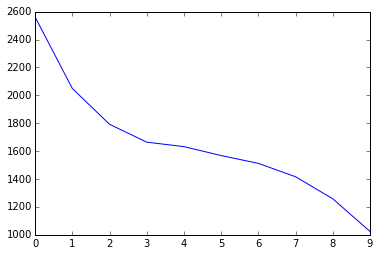

In [253]:
for ii, s in enumerate(thefdmt.hist_state_shape):
    print 'For iteration', ii, 'the output shape is [nc, nd]=', s[:2], 'which has size', s[0:2].prod()
    
sizes = [s[0:2].prod() for s in thefdmt.hist_state_shape]
print 'All sizes', sum(sizes), 'BRAMS', sum(sizes)*16/18e3, 'Or', max(sizes)*len(sizes)*16/18e3
plot(sizes)
    

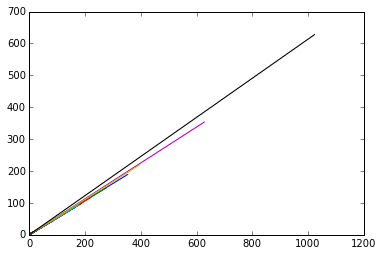

In [220]:
all_offsets = []
all_offsetse = []
all_offset_chan0 = []
iter_sums = []
for curr_iterno, theiter in enumerate(thefdmt.hist_nf_data):
    iter_sums.append(0)
    
    for ochan in xrange(len(theiter)):
        chanconfig = thefdmt.hist_nf_data[curr_iterno][ochan][-1]
        id1s = np.array([config[1] for config in chanconfig])
        id2s = np.array([config[3] for config in chanconfig])
        offsets = np.array([config[2] for config in chanconfig])
        _ = plot(offsets)
        #print curr_iterno, ochan, offsets.max()
        if ochan == 0:
            all_offset_chan0.append(offsets.max())
            
        all_offsets.append(offsets)
        all_offsetse.extend(offsets)
        iter_sums[-1] += sum(offsets)
        
    
        
all_offsetse = np.array(all_offsetse)


In [ ]:
semilogy(all_offset_chan0)

In [ ]:
all_offset_maxs = [o.max() for o in all_offsets]
plot(all_offset_maxs)

In [ ]:
fig, ax = subplots(1,2)
ax[0].plot(iter_sums)
ax[1].semilogy(iter_sums)
xlabel('Iteration')
ylabel('Sum of all offsets = amount of storage')

In [ ]:
semilogy(np.array(all_offsetse)+1)

In [ ]:
plot(np.array(all_offsetse))
xlabel('FIFO ID')
ylabel('FIFO Size')

In [ ]:
plot(np.array(all_offsetse[0:100]),'o')
xlabel('FIFO ID')
ylabel('FIFO Size')


In [ ]:
all_offsetse.sum()/2*16/18e3

In [ ]:
all_offsetse.sum()/2*16/288e3